In [1]:
import keras

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
path = "data/"
#path = "data/work_data/"
#path = "data/base_data/"
model_path = "model/"
batch_size=10

In [20]:
import utils; reload(utils)
from utils import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model
from keras.preprocessing import image
import os
from glob import glob
import numpy as np
import annotationHandler

In [4]:
size=(224,224)
batches = get_batches(path+'train', batch_size=batch_size, target_size=size, shuffle=False)
val_batches = get_batches(path+'validation', batch_size=batch_size, shuffle=False, target_size=size)

Found 3062 images belonging to 8 classes.
Found 715 images belonging to 8 classes.


In [5]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size,include_top=False)
model = vgg.model

for layer in model.layers:
    layer.trainable=False

/usr/local/lib64/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


vgg16_bn_conv.h5


In [6]:
train_bboxes = annotationHandler.create_bbx("data/annos", size, batches.filenames, path+"train")
val_bboxes = annotationHandler.create_bbx("data/annos", size, val_batches.filenames, path+"validation")

Annotations for 3297 images found.
Creating blank bounding boxes for the rest.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.


In [7]:
trainData = get_data(path+"train", target_size=size)
valData = get_data(path+"validation", target_size=size)

Found 3062 images belonging to 8 classes.
Found 715 images belonging to 8 classes.


In [21]:
valClass, trainClass, valClassOH, trainClassOH, valFiles, trainFiles, testFiles = utils.get_classes(path,include_test=True)

Found 3062 images belonging to 8 classes.
Found 715 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


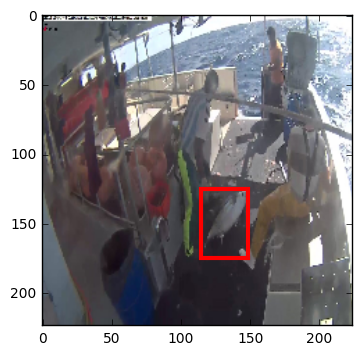

In [9]:
utils.show_bb(train_bboxes, trainData, 2)

In [10]:
p = 0.2
x = model.output
x = MaxPooling2D()(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [11]:
model = Model(input=model.input, output=[x_bb, x_class])
model.compile(Adam(lr=0.001), 
              loss=['mse', 'categorical_crossentropy'], 
              metrics=['accuracy'],
              loss_weights=[.001, 1.])

In [12]:
print(train_bboxes.shape)
print(trainData.shape)
print(trainClassOH.shape)

print(val_bboxes.shape)
print(valData.shape)
print(valClassOH.shape)

(3062, 4)
(3062, 3, 224, 224)
(3062, 8)
(715, 4)
(715, 3, 224, 224)
(715, 8)


In [13]:
model.fit(trainData, [train_bboxes,trainClassOH], 
          batch_size=batch_size, 
          nb_epoch=3, 
        validation_data=(valData, [val_bboxes, valClassOH]))

Train on 3062 samples, validate on 715 samples
Epoch 1/3
3062/3062 [==============================] - 99s - loss: 5.4510 - bb_loss: 4493.6731 - class_loss: 0.9573 - bb_acc: 0.4860 - class_acc: 0.7342 - val_loss: 3.3964 - val_bb_loss: 3053.4221 - val_class_loss: 0.3430 - val_bb_acc: 0.5776 - val_class_acc: 0.8979
Epoch 2/3
3062/3062 [==============================] - 98s - loss: 2.1704 - bb_loss: 1878.1939 - class_loss: 0.2922 - bb_acc: 0.6548 - class_acc: 0.9024 - val_loss: 0.9725 - val_bb_loss: 681.9169 - val_class_loss: 0.2906 - val_bb_acc: 0.7538 - val_class_acc: 0.9119
Epoch 3/3
3062/3062 [==============================] - 98s - loss: 0.7877 - bb_loss: 557.6186 - class_loss: 0.2300 - bb_acc: 0.7126 - class_acc: 0.9311 - val_loss: 0.6318 - val_bb_loss: 415.9460 - val_class_loss: 0.2158 - val_bb_acc: 0.7818 - val_class_acc: 0.9301


In [14]:
model.fit(trainData, [train_bboxes,trainClassOH], 
          batch_size=batch_size, 
          nb_epoch=10, 
        validation_data=(valData, [val_bboxes, valClassOH]))

Train on 3062 samples, validate on 715 samples
Epoch 1/10
3062/3062 [==============================] - 99s - loss: 0.5789 - bb_loss: 434.4951 - class_loss: 0.1444 - bb_acc: 0.7169 - class_acc: 0.9513 - val_loss: 0.5579 - val_bb_loss: 337.7338 - val_class_loss: 0.2201 - val_bb_acc: 0.7776 - val_class_acc: 0.9441
Epoch 2/10
3062/3062 [==============================] - 99s - loss: 0.5398 - bb_loss: 399.1234 - class_loss: 0.1407 - bb_acc: 0.7283 - class_acc: 0.9546 - val_loss: 0.5675 - val_bb_loss: 323.3159 - val_class_loss: 0.2442 - val_bb_acc: 0.7552 - val_class_acc: 0.9441
Epoch 3/10
3062/3062 [==============================] - 99s - loss: 0.4952 - bb_loss: 369.1115 - class_loss: 0.1261 - bb_acc: 0.7335 - class_acc: 0.9579 - val_loss: 0.5289 - val_bb_loss: 313.8014 - val_class_loss: 0.2151 - val_bb_acc: 0.7664 - val_class_acc: 0.9385
Epoch 4/10
3062/3062 [==============================] - 99s - loss: 0.4411 - bb_loss: 333.8779 - class_loss: 0.1072 - bb_acc: 0.7573 - class_acc: 0.9647 - 

In [15]:
model.save("model.keras")

## Submit

In [18]:
testData = get_data(path+"test", target_size=size)

Found 1000 images belonging to 1 classes.


In [23]:
preds = model.predict(testData, batch_size=batch_size*2)

In [34]:
filenames = testFiles
ids = np.array([f[4:] for f in filenames])
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)
subm = do_clip(preds[1],0.82)


In [36]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', ids)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00358.jpg,0.505759,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.460276
1,img_07173.jpg,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.820000
2,img_07143.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
3,img_05015.jpg,0.306355,0.025714,0.025714,0.665839,0.025714,0.025714,0.025714,0.025714
4,img_03229.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.050406


In [38]:
submission.to_csv('fishy2.csv', index=False)